<a href="https://colab.research.google.com/github/ByeongKeun/Industrial-AI/blob/master/2022_1_%EC%A7%80%EB%8A%A5%ED%99%94%EC%BA%A1%EC%8A%A4%ED%86%A4%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/%EA%B3%BC%EC%A0%9C/CNN%20%EB%B6%88%EB%9F%89%EB%B6%84%EB%A5%98/waferMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#library import - tensorflow/keras/sklearn/matplotlib
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
#dataset 구성
datapath = join('data', 'wafer')
url = "E:/WaferMap"
#print(os.listdir(url))  #dir list

#경고 메시지 끄기(ignore), 켜기(default)
import warnings
warnings.filterwarnings("ignore")

#read pickle 파일
#https://www.kaggle.com/code/kcs93023/keras-wafer-classification-cnn2d-with-augmentation/data
df=pd.read_pickle(url+"/LSWMD.pkl")


['archive.zip', 'LSWMD.pkl', 'LSWMD.pkl.zip', 'WaferMap']


> pickle 파일구성 (이미 학습할 수 있도록, 분류가 된 파일)
 - waferMap file 개수: 811,457 rows(2차원 행렬 data, 행*열=waferMapDim에 있음)
 - 6개 컬럼(wafer map, die size, lot name, index, T/T type, failType) 
  --> failuretype: 불량 유형 (none, edge-ring...)


> 데이터 구성

```
# none_label: 638,507 - 78.7%
# label: 172,950 - 21.3%   
   - ng: 25,519 	14.8%(3.1%) --> 불량 항목 별로도 데이터 불균형
   - ok: 147,431 	85.2%(18.2%)
```

In [ ]:
#data file 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trianTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
 5   waferMapDim     811457 non-null  object 
dtypes: float64(1), object(5)
memory usage: 37.1+ MB


In [ ]:
#해더 내용
df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [ ]:
#tail 내용
df.tail()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,[],[],"(26, 30)"
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,[],[],"(26, 30)"


In [ ]:
#csv 파일로도 한번 받아 봄(583mb)
df.to_csv(path_or_buf = 'wafermap.csv', \
           sep=str(','), header=True, index=True, mode='w', encoding='CP949')

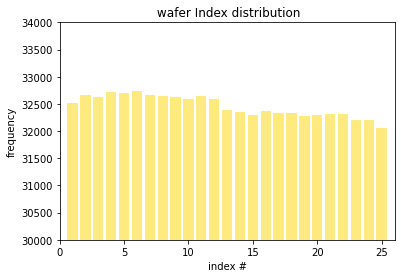

In [ ]:
# 1lot = 25장 wafer인데(1lot / wafer index = 1~25)
# lot의 wafer index 별로 보면, 없는 데이터도 존재 함
import matplotlib.pyplot as plt

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title("wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

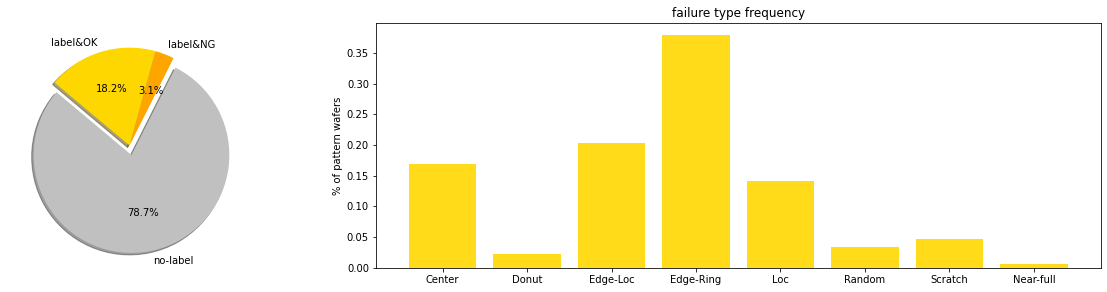

In [ ]:
#데이터 분포 라벨링율 = 21.3%
#데이터 분포 ok : ng = 85.2:14.8
#데이터 분포 ng(detection) 내 의 code별 분포
df['failureNum']=df.failureType #컬럼 추가
df['trainTestNum']=df.trianTestLabel    #컬럼 추가
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}    #불량코드 라벨링
mapping_traintest={'Training':0,'Test':1}   #train:0, test:1 로 라벨링
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})    #replace

#failureType의 label이 존재
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel = df_withlabel.reset_index()
#failureType의 label이 존재 && 불량z코드 존재 (0~7번 코드)
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
#failureType의 label이 존재 && OK품(8번 코드, none)
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

#graph - pie
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

tol_wafers = df.shape[0]
no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # pie에서 sclicing해서 차트에서 벗어나게
labels = ['no-label','label&NG','label&OK']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

#graph - bar
uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()
#

In [ ]:
#df head()
df[(df['failureNum']==8)].head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0


In [ ]:
# 구분별 개수 찍어 봄
print("total: ", tol_wafers)
print("none-label: ", tol_wafers -df_withlabel.shape[0])
print("label: ", df_withlabel.shape[0])
print("ng: ", df_withpattern.shape[0])
print("ok: ", df_nonpattern.shape[0])

total:  811457
none-label:  638507
label:  172950
ng:  25519
ok:  147431


In [ ]:
#wafer index 제외
df = df.drop(['waferIndex'], axis = 1)

In [ ]:
#각 wafer map의 해상도 size가 다름 -- 해상도 size에 대한(행렬size) 컬럼과 데이터 생성
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
158981,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1,...",515.0,lot10237,[[Training]],[[Center]],"(25, 27)"
487489,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",710.0,lot30167,[],[],"(32, 29)"
600371,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37728,[],[],"(49, 39)"
502224,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot31209,[],[],"(32, 29)"
341368,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3642.0,lot20474,[],[],"(64, 72)"


In [ ]:
#26*26 해상도의 wafer data 추출
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # 불량코드에 null 라벨의 skip 처리
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

# x, y shape
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


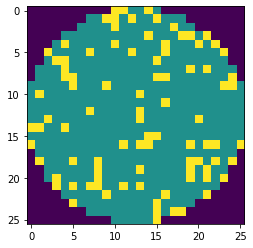

Faulty case : ['none'] 


In [ ]:
# plot 1st data 보여주고
plt.imshow(x[0])
plt.show()

# check faulty case: failure type
print('Faulty case : {} '.format(y[0]))

In [ ]:
#add channel
x = x.reshape((-1, 26, 26, 1))

faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
#26*26 size map의 failure type별 데이터 개수
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [ ]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [ ]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [ ]:
# parameter
epoch=15
batch_size=1024

# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

In [ ]:
# start train
ae_history = ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
20/20 - 14s - loss: 0.0090
Epoch 2/15
20/20 - 14s - loss: 0.0072
Epoch 3/15
20/20 - 14s - loss: 0.0067
Epoch 4/15
20/20 - 14s - loss: 0.0065
Epoch 5/15
20/20 - 13s - loss: 0.0063
Epoch 6/15
20/20 - 14s - loss: 0.0061
Epoch 7/15
20/20 - 14s - loss: 0.0060
Epoch 8/15
20/20 - 14s - loss: 0.0059
Epoch 9/15
20/20 - 14s - loss: 0.0058
Epoch 10/15
20/20 - 14s - loss: 0.0057
Epoch 11/15
20/20 - 14s - loss: 0.0056
Epoch 12/15
20/20 - 14s - loss: 0.0055
Epoch 13/15
20/20 - 13s - loss: 0.0054
Epoch 14/15
20/20 - 14s - loss: 0.0053
Epoch 15/15
20/20 - 13s - loss: 0.0052


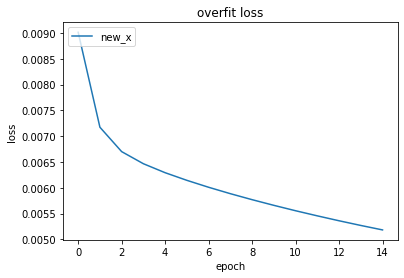

In [ ]:
# loss chart - 데이터 불균형 그대로 .. 과적합 검증
# loss plot
plt.plot(ae_history.history['loss'])
plt.title('overfit loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['new_x'], loc='upper left')
plt.show()

In [ ]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
decoder = models.Model(decoder_input, output_tensor(decode))

# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

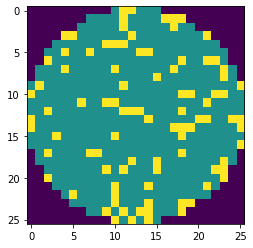

In [ ]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

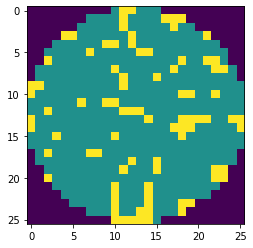

In [ ]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

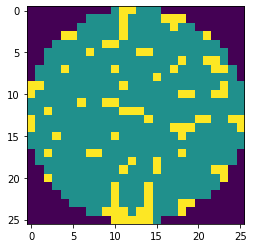

In [ ]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])


# ------------------ Data augmentation ------------------------

In [ ]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [ ]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [ ]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [ ]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [ ]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [ ]:
# faulty_case count
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [ ]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


In [ ]:
# The data is ready. As wafer data is image. simply use cnn for classification.

In [ ]:
# The data is ready. As wafer data is image. simply use cnn for classification.
# Make model
# define create model function, because we will validate model with sklearn kfold cross validation.
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [ ]:
# Cross validate model: Using sklearn KFold Cross validation, we validate our simple cnn.

# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
9/9 - 19s - loss: 2.1219 - accuracy: 0.3433
Epoch 2/10
9/9 - 18s - loss: 1.0267 - accuracy: 0.6078
Epoch 3/10
9/9 - 19s - loss: 0.5506 - accuracy: 0.8333
Epoch 4/10
9/9 - 18s - loss: 0.3335 - accuracy: 0.8917
Epoch 5/10
9/9 - 18s - loss: 0.2399 - accuracy: 0.9231
Epoch 6/10
9/9 - 18s - loss: 0.1388 - accuracy: 0.9594
Epoch 7/10
9/9 - 18s - loss: 0.0803 - accuracy: 0.9798
Epoch 8/10
9/9 - 18s - loss: 0.0516 - accuracy: 0.9865
Epoch 9/10
9/9 - 18s - loss: 0.0322 - accuracy: 0.9918
Epoch 10/10
9/9 - 18s - loss: 0.0184 - accuracy: 0.9968
5/5 - 3s - loss: 0.0798 - accuracy: 0.9784
Epoch 1/10
9/9 - 18s - loss: 2.3096 - accuracy: 0.3192
Epoch 2/10
9/9 - 18s - loss: 1.1035 - accuracy: 0.6005
Epoch 3/10
9/9 - 18s - loss: 0.6619 - accuracy: 0.7711
Epoch 4/10
9/9 - 18s - loss: 0.5198 - accuracy: 0.8473
Epoch 5/10
9/9 - 18s - loss: 0.2916 - accuracy: 0.9154
Epoch 6/10
9/9 - 18s - loss: 0.1789 - accuracy: 0.9430
Epoch 7/10
9/9 - 18s - loss: 0.1141 - accuracy: 0.9657
Epoch 8/10
9/9 - 18s 

In [ ]:
batch_size

1024

In [ ]:
print(x_test.shape)
print(y_test.shape)

(6504, 26, 26, 3)
(6504, 9)


In [ ]:
print(x_train.shape)
print(y_train.shape)

(13203, 26, 26, 3)
(13203, 9)


In [ ]:
y_train.dtype

dtype('float32')

In [ ]:
# Our model seems quite a good model.
history = model.fit(x_train, y_train,         
         epochs=epoch,
         batch_size=batch_size,
         validation_data=(x_test, y_test)
         )

Epoch 1/15
13/13 - 32s - loss: 1.7748 - accuracy: 0.4422 - val_loss: 0.9194 - val_accuracy: 0.5846
Epoch 2/15
13/13 - 31s - loss: 0.7695 - accuracy: 0.7288 - val_loss: 0.5789 - val_accuracy: 0.8267
Epoch 3/15
13/13 - 33s - loss: 0.4003 - accuracy: 0.8803 - val_loss: 0.3091 - val_accuracy: 0.8930
Epoch 4/15
13/13 - 32s - loss: 0.1894 - accuracy: 0.9459 - val_loss: 0.1450 - val_accuracy: 0.9550
Epoch 5/15
13/13 - 32s - loss: 0.0951 - accuracy: 0.9716 - val_loss: 0.0857 - val_accuracy: 0.9717
Epoch 6/15
13/13 - 32s - loss: 0.0509 - accuracy: 0.9874 - val_loss: 0.0516 - val_accuracy: 0.9855
Epoch 7/15
13/13 - 32s - loss: 0.0263 - accuracy: 0.9948 - val_loss: 0.0430 - val_accuracy: 0.9869
Epoch 8/15
13/13 - 32s - loss: 0.0201 - accuracy: 0.9950 - val_loss: 0.0380 - val_accuracy: 0.9879
Epoch 9/15
13/13 - 32s - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.0392 - val_accuracy: 0.9882
Epoch 10/15
13/13 - 32s - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.0324 - val_accuracy: 0.9886
Epoch 11/

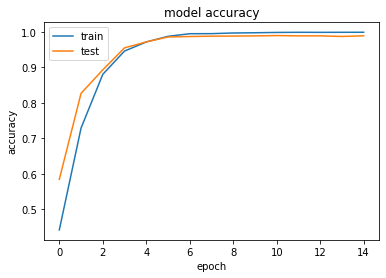

In [ ]:
# accuracy chart
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

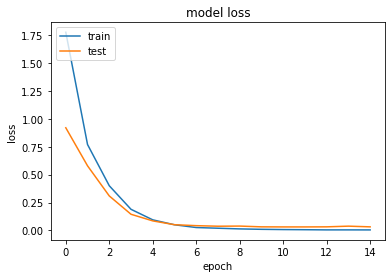

In [ ]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()